In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
import numpy as np
import pickle
from sklearn.impute import KNNImputer
import imblearn

from utils.general_utils import get_outlier_info, get_outlier_val_counts
from utils.saver_utils import save_normalizer, load_normalizer
from utils.saver_utils import save_dataset, load_dataset 

## TODO 
1. Stratified split
2. Handle class imbalance
3. Handle outliers

In [21]:
og_df = pd.read_csv('dataset/TrainDataset2023.csv')
og_df.rename(columns={'pCR (outcome)': 'pcr', 'RelapseFreeSurvival (outcome)': 'rfs'}, inplace=True)

In [22]:
columns_drop_path = 'dataset/dataset_v1/columns_dropped.pkl'

with open(columns_drop_path, 'rb') as f:
    to_drop_90 = pickle.load(f)

In [23]:
fs_df_v1 = og_df.drop(to_drop_90, axis=1)

In [24]:
impute_knn = KNNImputer(n_neighbors=3, missing_values=999)
imputed_arr = impute_knn.fit_transform(fs_df_v1.drop(columns=['ID']))
imputed_df = pd.DataFrame.from_records(imputed_arr, columns=fs_df_v1.columns[1:])

In [25]:
# imputed_df.to_csv('dataset/dataset_v1/imputed_df.csv')

In [26]:
imputed_df.head()

,pcr,rfs,Age,ER,PgR,ChemoGrade,Proliferation,LNStatus,TumourStage,original_shape_Elongation,...,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_ngtdm_Busyness,original_ngtdm_Strength
0,1.0,144.0,41.0,0.0,0.0,3.0,3.0,1.0,2.0,0.813912,...,1.272727,4067578.818,1.565522e+07,1.170667e+06,0.180900,0.403535,3.325332,0.002314,473.464852,0.000758
1,0.0,142.0,39.0,1.0,1.0,3.0,3.0,1.0,2.0,0.666118,...,1.037500,2403756.075,9.614769e+06,6.010027e+05,0.198125,0.444391,3.032144,0.005612,59.459710,0.003685
2,1.0,135.0,31.0,0.0,0.0,2.0,1.0,0.0,2.0,0.645083,...,1.040541,1561963.432,6.247801e+06,3.905040e+05,0.275749,0.534549,2.485848,0.006752,33.935384,0.006447
3,0.0,12.0,35.0,0.0,0.0,3.0,3.0,1.0,3.0,0.770842,...,1.029703,7007670.723,2.803063e+07,1.751932e+06,0.253014,0.506185,2.606255,0.003755,46.859265,0.004543
4,0.0,109.0,61.0,1.0,0.0,2.0,1.0,0.0,2.0,0.861035,...,1.051724,1288913.690,5.155465e+06,3.222760e+05,0.216409,0.462282,2.809279,0.006521,39.621023,0.005626


## Identified that below three feature columns when the feature itself is categorical. So we round it to the closest integer

1. ChemoGrade
2. Proliferation
3. LNStatus

## Also the classification target variable had float values so rounding that too.
1. PCR

In [27]:
imputed_df['ChemoGrade'] = imputed_df['ChemoGrade'].round()
imputed_df['Proliferation'] = imputed_df['Proliferation'].round()
imputed_df['LNStatus'] = imputed_df['LNStatus'].round()
imputed_df['pcr'] = imputed_df['pcr'].round()

In [28]:
imputed_df['TumourStage'].value_counts()

TumourStage
2.0    183
3.0    104
4.0     84
1.0     29
Name: count, dtype: int64

In [29]:
imputed_df['ChemoGrade'].value_counts(), imputed_df['Proliferation'].value_counts(), imputed_df['TumourStage'].value_counts()

(ChemoGrade
 2.0    236
 3.0    162
 1.0      2
 Name: count, dtype: int64,
 Proliferation
 1.0    239
 2.0     93
 3.0     68
 Name: count, dtype: int64,
 TumourStage
 2.0    183
 3.0    104
 4.0     84
 1.0     29
 Name: count, dtype: int64)

# Converting categorical value to one hot encoding 
### Following are the categorical features which has more than 2 categories
1. ChemoGrade
2. Proliferation
3. TumourStage

In [30]:
imputed_df = pd.get_dummies(imputed_df, columns=['ChemoGrade', 'Proliferation', 'TumourStage'])

In [31]:
imputed_df.head()

,pcr,rfs,Age,ER,PgR,LNStatus,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,...,ChemoGrade_1.0,ChemoGrade_2.0,ChemoGrade_3.0,Proliferation_1.0,Proliferation_2.0,Proliferation_3.0,TumourStage_1.0,TumourStage_2.0,TumourStage_3.0,TumourStage_4.0
0,1.0,144.0,41.0,0.0,0.0,1.0,0.813912,0.724080,23.781937,32.844370,...,False,False,True,False,False,True,False,True,False,False
1,0.0,142.0,39.0,1.0,1.0,1.0,0.666118,0.476173,20.715461,43.504095,...,False,False,True,False,False,True,False,True,False,False
2,1.0,135.0,31.0,0.0,0.0,0.0,0.645083,0.594470,21.659822,36.435505,...,False,True,False,True,False,False,False,True,False,False
3,0.0,12.0,35.0,0.0,0.0,1.0,0.770842,0.501228,26.590504,53.050724,...,False,False,True,False,False,True,False,False,True,False
4,0.0,109.0,61.0,1.0,0.0,0.0,0.861035,0.750267,20.456571,27.265716,...,False,True,False,True,False,False,False,True,False,False


### Converting bool one hot encoding to integer one hot encoding

In [32]:
multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

In [33]:
for column in multi_category_variables:
    imputed_df[column] = imputed_df[column].astype(np.float32)

In [34]:
imputed_df[multi_category_variables]

,ChemoGrade_1.0,ChemoGrade_2.0,ChemoGrade_3.0,Proliferation_1.0,Proliferation_2.0,Proliferation_3.0,TumourStage_1.0,TumourStage_2.0,TumourStage_3.0,TumourStage_4.0
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
396,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
397,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
398,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [35]:
train, test = train_test_split(imputed_df, test_size=0.20)

In [36]:
train.shape, test.shape

((320, 62), (80, 62))

## Separating categorical and continous data separately to process

In [37]:
multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = ['ER', 'PgR', 'LNStatus'] + multi_category_variables

continous_features_labels = imputed_df.drop(columns=categorical_features_labels+['pcr', 'rfs']).columns

In [38]:
len(categorical_features_labels), len(continous_features_labels)

(13, 47)

In [39]:
train_continous_feature_array = train[continous_features_labels].to_numpy()

test_continous_feature_array = test[continous_features_labels].to_numpy()

In [41]:
scalerTrainX = StandardScaler()

train_cont_X = scalerTrainX.fit_transform(train_continous_feature_array)
train_cat_X = train[categorical_features_labels].to_numpy()
trainX = np.hstack((train_cat_X, train_cont_X))
                   
trainY = train['pcr'].to_numpy().reshape(-1, 1)

                   
test_cont_X = scalerTrainX.transform(test_continous_feature_array)
test_cat_X = test[categorical_features_labels].to_numpy()
testX = np.hstack((test_cat_X, test_cont_X))
                   
testY = test['pcr'].to_numpy().reshape(-1, 1)


In [62]:
dataset_save_path = "dataset/dataset_v2"

In [63]:
# imputed_df.to_csv(f"{dataset_save_path}/imputed_df.csv")
# save_dataset(xTrain=trainX, yTrain=trainY, xTest=testX, yTest=testY,
#              path=f'{dataset_save_path}/')
# save_normalizer(path=f'{dataset_save_path}/', Xnormalizer=scalerTrainX, task='classification')

Caution, saving dataset in order!.. Check arguments
Saving for classification task


In [2]:
datasetv2_save_path = "dataset/dataset_v2"
trainX, trainY, testX, testY = load_dataset(path=datasetv2_save_path)
scalerTrainX = load_normalizer(path=datasetv2_save_path, task='classification')

Caution, loading dataset in order!.. Check arguments
Loading for classification task


In [42]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((320, 60), (320, 1), (80, 60), (80, 1))

In [43]:
train_unique_values, train_counts = np.unique(trainY, return_counts=True) 
test_unique_values, test_counts = np.unique(testY, return_counts=True) 

print(f'Train Value counts : {train_unique_values, train_counts}')
print(f'Test Value counts : {test_unique_values, test_counts}')

print(f'Imbalance train ratio : {max(train_counts)/min(train_counts)}')
print(f'Imbalance test ratio : {max(test_counts)/min(test_counts)}')

Train Value counts : (array([0., 1.]), array([253,  67], dtype=int64))
Test Value counts : (array([0., 1.]), array([63, 17], dtype=int64))
Imbalance train ratio : 3.7761194029850746
Imbalance test ratio : 3.7058823529411766


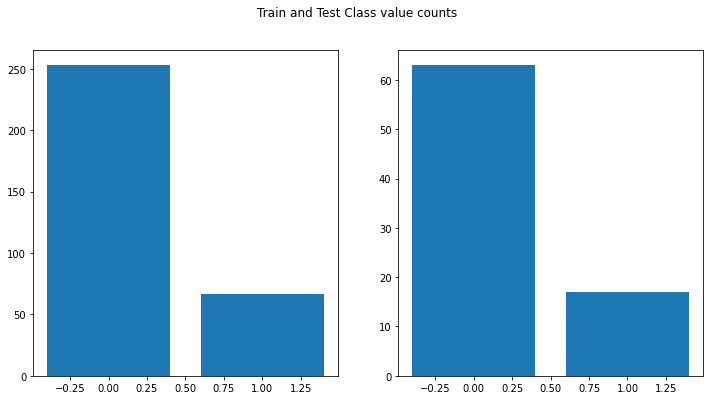

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].bar(x=train_unique_values, height=train_counts)
axes[1].bar(x=test_unique_values, height=test_counts)

fig.suptitle('Train and Test Class value counts')

plt.show()

# Classification Task split and z-score normalization

# Model training 
### Random Forest

1. Vanilla training with imbalanced dataset, without any hyperparameter optimization

In [3]:
from sklearn.ensemble import RandomForestClassifier
from utils.general_utils import save_model
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

import imblearn
from imblearn.pipeline import Pipeline

In [53]:
np.unique(trainY, return_counts=True), len(trainY)

((array([0., 1.]), array([253,  67], dtype=int64)), 320)

In [47]:
class1_mask = trainY == 1
sample_weights = np.zeros_like(trainY)
sample_weights[:,:] = 0.3
sample_weights[class1_mask] = 0.7 

In [55]:
_, class_counts = np.unique(trainY, return_counts=True)
class_weights = {0: 1.0, 1: len(trainY) / (2 * class_counts[1])}
class_weights

{0: 1.0, 1: 2.388059701492537}

In [56]:
classifier = RandomForestClassifier(random_state=0, verbose=0, class_weight=class_weights) #class_weight='balanced'

In [57]:
classifier.fit(trainX, trainY.ravel(), sample_weight=sample_weights.ravel())

RandomForestClassifier(class_weight={0: 1.0, 1: 2.388059701492537},
                       random_state=0)

In [59]:
predicted = classifier.predict(testX)
test_bas_error = balanced_accuracy_score(testY, predicted)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)


print(f'Balanced classification accuracy : {test_bas_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')
print()
print(classification_report(testY, predicted))

Balanced classification accuracy : 0.5
MAE error: 0.2125
R2 error: -0.26984126984127

              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88        63
         1.0       0.00      0.00      0.00        17

    accuracy                           0.79        80
   macro avg       0.39      0.50      0.44        80
weighted avg       0.62      0.79      0.69        80



C:\Users\sudar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[63  0]
 [17  0]]


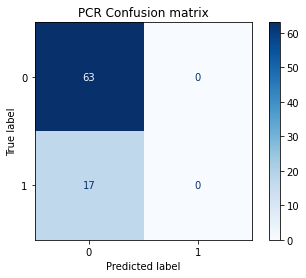

In [60]:
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        testX,
        testY,
        display_labels=['0','1'],
        cmap=plt.cm.Blues,
        normalize=None)
    
disp.ax_.set_title("PCR Confusion matrix")
print(disp.confusion_matrix)

plt.show()

# Handling class imbalance using SMOTE

In [4]:
from sklearn.manifold import TSNE # TSNE module
from sklearn.decomposition import PCA

C:\Users\sudar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.001s...
[t-SNE] Computed neighbors for 320 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 2.506121
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.466442
[t-SNE] KL divergence after 1000 iterations: 0.728763


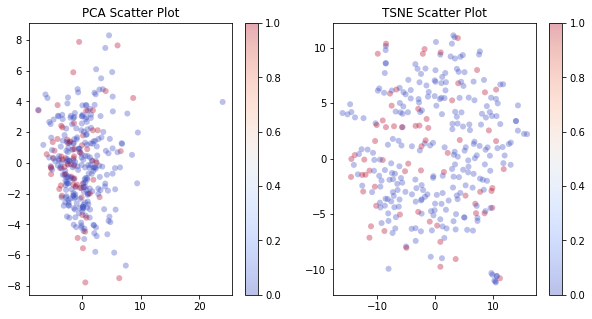

In [62]:
X = trainX
Labels = trainY

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X)

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

# Plot the TSNE and PCA visuals side-by-side
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.scatter(pca_2d[:,0], pca_2d[:,1], c = Labels,
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('PCA Scatter Plot')

plt.subplot(122)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = Labels,
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

In [63]:
# oversample = imblearn.over_sampling.BorderlineSMOTE(sampling_strategy=1)
oversample = imblearn.over_sampling.ADASYN()


imputed_x, imputed_y = oversample.fit_resample(trainX, trainY)

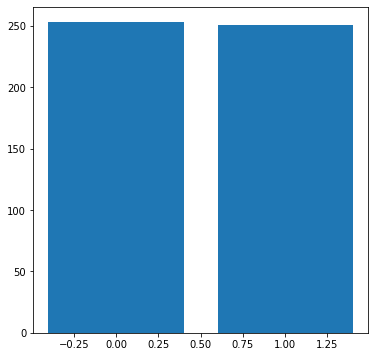

In [64]:
train_unique_values, train_counts = np.unique(imputed_y, return_counts=True) 

plt.figure(figsize=(6,6))

plt.bar(x=train_unique_values, height=train_counts)

plt.show()

C:\Users\sudar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 504 samples in 0.001s...
[t-SNE] Computed neighbors for 504 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 504 / 504
[t-SNE] Mean sigma: 2.333105
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.729172
[t-SNE] KL divergence after 1000 iterations: 0.760443


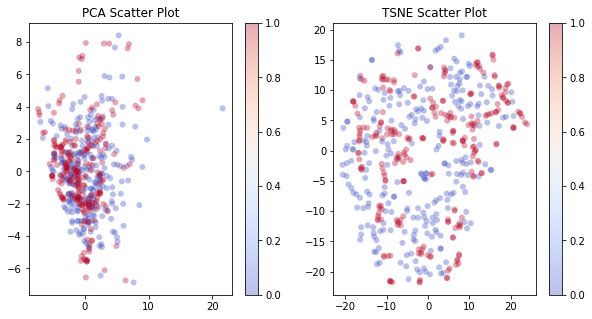

In [65]:
X = imputed_x
Labels = imputed_y

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X)

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

# Plot the TSNE and PCA visuals side-by-side
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.scatter(pca_2d[:,0], pca_2d[:,1], c = Labels,
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('PCA Scatter Plot')

plt.subplot(122)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = Labels,
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

In [70]:
# classifier = RandomForestClassifier(random_state=0, n_estimators=50, min_samples_split=5, max_depth=15, criterion='entropy', verbose=0) #class_weight='balanced'
classifier = RandomForestClassifier(random_state=42, verbose=0) #class_weight='balanced'

In [71]:
classifier.fit(imputed_x, imputed_y.ravel())

RandomForestClassifier(random_state=42)

In [72]:
predicted = classifier.predict(testX)
test_bas_error = balanced_accuracy_score(testY, predicted)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)


print(f'Balanced classification accuracy : {test_bas_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')
print()
print(classification_report(testY, predicted))

Balanced classification accuracy : 0.44211017740429503
MAE error: 0.3375
R2 error: -1.0168067226890756

              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79        63
         1.0       0.08      0.06      0.07        17

    accuracy                           0.66        80
   macro avg       0.42      0.44      0.43        80
weighted avg       0.62      0.66      0.64        80



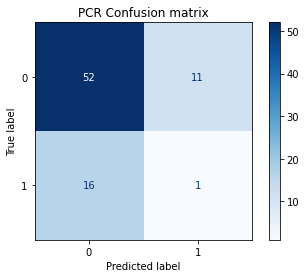

In [73]:
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        testX,
        testY,
        display_labels=['0','1'],
        cmap=plt.cm.Blues,
        normalize=None)
    
disp.ax_.set_title("PCR Confusion matrix")
# print(disp.confusion_matrix)

plt.show()

## Handling class imbalance by using BalancedRandomForest Classifier

In [133]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [148]:
# oversample = imblearn.over_sampling.BorderlineSMOTE(sampling_strategy=1)
oversample = imblearn.over_sampling.ADASYN(sampling_strategy=0.7)


imputed_x, imputed_y = oversample.fit_resample(trainX, trainY)

In [164]:
# pca = PCA(n_components=10)
# pca_train = pca.fit_transform(imputed_x)
# pca_test = pca.transform(testX)

pca = PCA(n_components=6)
pca_train = pca.fit_transform(trainX)
pca_test = pca.transform(testX)

In [165]:
classifier = BalancedRandomForestClassifier(random_state=42, verbose=0, class_weight={0:1, 1:3}) #class_weight='balanced'
# classifier.fit(imputed_x, imputed_y.ravel())
classifier.fit(pca_train, trainY.ravel())

C:\Users\sudar\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\sudar\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier(class_weight={0: 1, 1: 3}, random_state=42)

In [166]:
predicted = classifier.predict(pca_test)
test_bas_error = balanced_accuracy_score(testY, predicted)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)


print(f'Balanced classification accuracy : {test_bas_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')
print()
print(classification_report(testY, predicted))

Balanced classification accuracy : 0.4741156169111303
MAE error: 0.3875
R2 error: -1.1397756686798965

              precision    recall  f1-score   support

         0.0       0.75      0.74      0.74        61
         1.0       0.20      0.21      0.21        19

    accuracy                           0.61        80
   macro avg       0.47      0.47      0.47        80
weighted avg       0.62      0.61      0.62        80



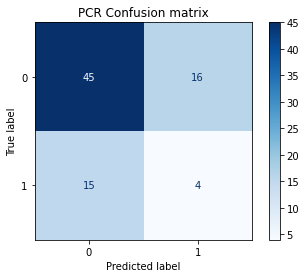

In [167]:
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        pca_test,
        testY,
        display_labels=['0','1'],
        cmap=plt.cm.Blues,
        normalize=None)
    
disp.ax_.set_title("PCR Confusion matrix")
# print(disp.confusion_matrix)

plt.show()

## Using Gradient Boosting classifier from scikit learn

In [147]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score


In [108]:
gb_classifier = GradientBoostingClassifier(max_depth=3)

### TODO

1. Choose parameters for hyperparameter optimization


In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

print('Best Criterion:', clf_GS.best_estimator_.get_params()['criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['max_depth'])
print('Best Number Of min_samples_leaf:', clf_GS.best_estimator_.get_params()['min_samples_leaf'])
print('Best Number Of min_samples_split:', clf_GS.best_estimator_.get_params()['min_samples_split'])

In [111]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(gb_classifier, trainX, trainY.ravel(),
                           scoring=make_scorer(balanced_accuracy_score), cv=cv, n_jobs=-1,
                           error_score='raise')
print('Balanced Classification Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Balanced Classification Accuracy: 0.502 (0.061)


In [112]:
n_scores

array([0.48      , 0.48      , 0.53142857, 0.51142857, 0.5       ,
       0.46      , 0.53142857, 0.54487179, 0.56410256, 0.40384615,
       0.64285714, 0.46      , 0.53142857, 0.46      , 0.62285714,
       0.51142857, 0.57142857, 0.42307692, 0.56410256, 0.5       ,
       0.44      , 0.55142857, 0.60285714, 0.41142857, 0.5       ,
       0.46      , 0.48      , 0.42307692, 0.46153846, 0.44230769])

In [102]:
gb_classifier.fit(trainX, trainY.ravel())

GradientBoostingClassifier(max_depth=10)

In [103]:
predicted = gb_classifier.predict(testX)
test_bas_error = balanced_accuracy_score(testY, predicted)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)


print(f'Balanced classification accuracy : {test_bas_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')
print()
print(classification_report(testY, predicted))

Balanced classification accuracy : 0.4850606909430439
MAE error: 0.3375
R2 error: -1.0168067226890756

              precision    recall  f1-score   support

         0.0       0.78      0.79      0.79        63
         1.0       0.19      0.18      0.18        17

    accuracy                           0.66        80
   macro avg       0.48      0.49      0.48        80
weighted avg       0.66      0.66      0.66        80



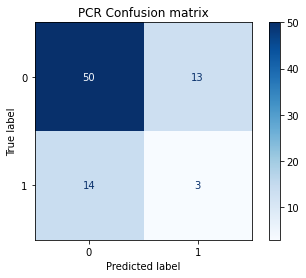

In [104]:
disp = ConfusionMatrixDisplay.from_estimator(
        gb_classifier,
        testX,
        testY,
        display_labels=['0','1'],
        cmap=plt.cm.Blues,
        normalize=None)
    
disp.ax_.set_title("PCR Confusion matrix")
# print(disp.confusion_matrix)

plt.show()

## Using XGBoost from xgboost 

In [60]:
import xgboost

## Training with true data without any data generation, but using PCA top 6 features

In [64]:
pca = PCA(n_components=6)
pca_train = pca.fit_transform(trainX)
pca_test = pca.transform(testX)

In [65]:
_, class_counts = np.unique(trainY, return_counts=True)
eval_set = [(pca_test, testY)]
class_weight = class_counts[0] / class_counts[1]

xgbclassifier = xgboost.XGBClassifier(objective='binary:logistic',scale_pos_weight=class_weight,
                                      eval_metric=["error", "logloss"])
xgbclassifier.fit(pca_train, trainY.ravel(),eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['error', 'logloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [66]:
predicted = xgbclassifier.predict(pca_test)
test_bas_error = balanced_accuracy_score(testY, predicted)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)


print(f'Balanced classification accuracy : {test_bas_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')
print()
print(classification_report(testY, predicted))

Balanced classification accuracy : 0.5297670405522001
MAE error: 0.275
R2 error: -0.5185504745470233

              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83        61
         1.0       0.33      0.16      0.21        19

    accuracy                           0.73        80
   macro avg       0.55      0.53      0.52        80
weighted avg       0.67      0.72      0.69        80



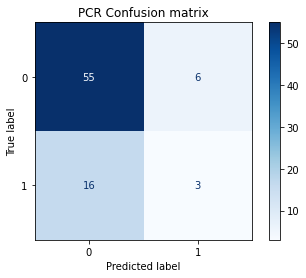

In [67]:
disp = ConfusionMatrixDisplay.from_estimator(
        xgbclassifier,
        pca_test,
        testY,
        display_labels=['0','1'],
        cmap=plt.cm.Blues,
        normalize=None)
    
disp.ax_.set_title("PCR Confusion matrix")
# print(disp.confusion_matrix)

plt.show()

## Training with true data without any data generation


In [140]:
_, class_counts = np.unique(trainY, return_counts=True)
eval_set = [(testX, testY)]
class_weight = class_counts[0] / class_counts[1]

xgbclassifier = xgboost.XGBClassifier(objective='binary:logistic',scale_pos_weight=class_weight,
                                      eval_metric=["error", "logloss"])

In [147]:
xgbclassifier.fit(trainX, trainY.ravel(),eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['error', 'logloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Training with data generation using BorderlineSMOTE

In [94]:
# oversample = imblearn.over_sampling.BorderlineSMOTE(sampling_strategy=1)
oversample = imblearn.over_sampling.BorderlineSMOTE(sampling_strategy=0.7, k_neighbors=2, m_neighbors=3)
# oversample = imblearn.over_sampling.BorderlineSMOTE(sampling_strategy=0.7, random_state=88, k_neighbors=2, m_neighbors=5)


imputed_x, imputed_y = oversample.fit_resample(trainX, trainY)

In [95]:
pca = PCA(n_components=6)
pca_imputedtrainX = pca.fit_transform(imputed_x)
pca_test = pca.transform(testX)

In [96]:
_, class_counts = np.unique(imputed_y, return_counts=True)
eval_set = [(pca_test, testY)]
class_weight = class_counts[0] / class_counts[1]

In [107]:
xgbclassifier = xgboost.XGBClassifier(objective='binary:logistic',scale_pos_weight=1,
                                      eval_metric=["error", "logloss"])

In [108]:
xgbclassifier.fit(pca_imputedtrainX, imputed_y.ravel(),eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['error', 'logloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [109]:
# _, class_counts = np.unique(trainY, return_counts=True)
# class_weights = {0: 1.0, 1: len(trainY) / (2 * class_counts[1])}
# class_weights

In [110]:
predicted = xgbclassifier.predict(pca_test)
test_bas_error = balanced_accuracy_score(testY, predicted)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)


print(f'Balanced classification accuracy : {test_bas_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')
print()
print(classification_report(testY, predicted))

Balanced classification accuracy : 0.5806729939603106
MAE error: 0.225
R2 error: -0.2424503882657465

              precision    recall  f1-score   support

         0.0       0.79      0.95      0.87        61
         1.0       0.57      0.21      0.31        19

    accuracy                           0.78        80
   macro avg       0.68      0.58      0.59        80
weighted avg       0.74      0.78      0.73        80



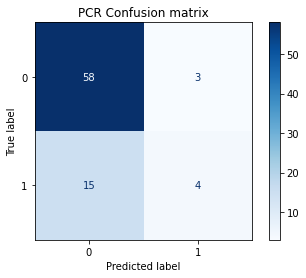

In [111]:
disp = ConfusionMatrixDisplay.from_estimator(
        xgbclassifier,
        pca_test,
        testY,
        display_labels=['0','1'],
        cmap=plt.cm.Blues,
        normalize=None)
    
disp.ax_.set_title("PCR Confusion matrix")
# print(disp.confusion_matrix)

plt.show()

# Using Linear Discriminant analysis

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [56]:
pca = PCA(n_components=6)
pca_train = pca.fit_transform(trainX)

In [57]:
pca.explained_variance_

array([10.96088073,  6.87505384,  5.91482376,  4.81529909,  3.72041628,
        2.68573607])

In [49]:
pca_train.shape, trainX.shape

((320, 20), (320, 60))

In [50]:
ldmodel = LinearDiscriminantAnalysis(solver='svd')

In [51]:
ldmodel.fit(pca_train, trainY.ravel())

LinearDiscriminantAnalysis()

In [52]:
pca_test = pca.transform(testX)

In [53]:
predicted = ldmodel.predict(pca_test)
test_bas_error = balanced_accuracy_score(testY, predicted)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)


print(f'Balanced classification accuracy : {test_bas_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')
print()
print(classification_report(testY, predicted))

Balanced classification accuracy : 0.5017256255392579
MAE error: 0.2625
R2 error: -0.4495254529767041

              precision    recall  f1-score   support

         0.0       0.76      0.95      0.85        61
         1.0       0.25      0.05      0.09        19

    accuracy                           0.74        80
   macro avg       0.51      0.50      0.47        80
weighted avg       0.64      0.74      0.67        80



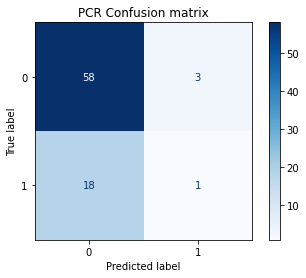

In [54]:
disp = ConfusionMatrixDisplay.from_estimator(
        ldmodel,
        pca_test,
        testY,
        display_labels=['0','1'],
        cmap=plt.cm.Blues,
        normalize=None)
    
disp.ax_.set_title("PCR Confusion matrix")
# print(disp.confusion_matrix)

plt.show()